In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import coordinates as coords
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Galactic
import astropy.units as u
import dunestyle.matplotlib as dunestyle


DUNE plot style enabled


In [4]:
# Constants
r_s = 20.0  # kpc #20.0
rho_0 = 0.184  # GeV/cm^3
R_sun = 8.122  # kpc

def rho_NFW(r):
    return rho_0 * (r_s / r) / (1 + r / r_s)**2

def r_galcen(l_deg, b_deg, s):
    l_rad = np.radians(l_deg)
    b_rad = np.radians(b_deg)
    return np.sqrt(R_sun**2 + s**2 - 2 * R_sun * s * np.cos(b_rad) * np.cos(l_rad))

def los_integral(l, b, s_max=300, steps=1000):
    s_vals = np.linspace(0.01, s_max, steps)
    r_vals = r_galcen(l, b, s_vals)
    rho_vals = rho_NFW(r_vals)
    return np.trapz(rho_vals, s_vals)

# Grid
n_pix = 100
l_vals = np.linspace(-180, 180, n_pix)
b_vals = np.linspace(-90, 90, n_pix // 2)
L, B = np.meshgrid(l_vals, b_vals)

# Compute LOS integral
print("Computing LOS integrals...")
rho_proj = np.zeros_like(L)
Alt = np.zeros_like(L)
Azimuth = np.zeros_like(L)
for i in range(B.shape[0]):
    for j in range(L.shape[1]):
        rho_proj[i, j] = los_integral(L[i, j], B[i, j])

# Convert to radians
L_rad = np.radians(L)
B_rad = np.radians(B)
L_rad = np.where(L_rad > np.pi, L_rad - 2*np.pi, L_rad)




Computing LOS integrals...


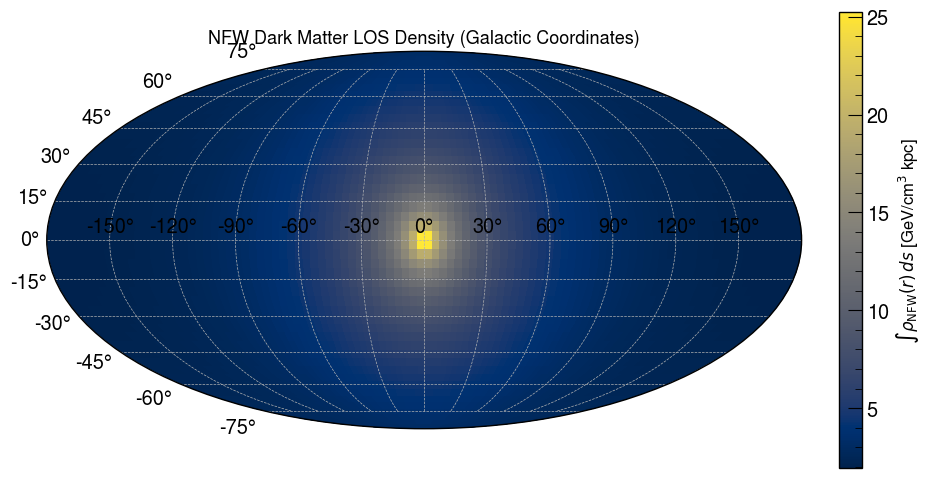

In [5]:
# Plot
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='mollweide')

# Change colormap here: 'plasma', 'cividis', 'magma', 'coolwarm', etc.
cmap_choice = 'cividis'
pc = ax.pcolormesh(L_rad, B_rad, rho_proj, cmap=cmap_choice, shading='auto')

# Colorbar on the side
cbar = plt.colorbar(pc, ax=ax, orientation='vertical', pad=0.04, shrink=0.8)
cbar.set_label(r'$\int \rho_\mathrm{NFW}(r)\,ds$ [GeV/cm$^3$ kpc]', fontsize=12)

ax.set_title("NFW Dark Matter LOS Density (Galactic Coordinates)", fontsize=13)
ax.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# --- DUNE location
dune_location = EarthLocation(lat=44.352*u.deg, lon=-103.751*u.deg, height=100*u.m)

# --- Time samples (one year span, 100 samples)
current_time = Time.now() + 10 * u.year
end_time = current_time + 1 * u.year

N_skies = 3*360 # Number of sampled skies in one year - 3 per day

times = Time(np.linspace(current_time.jd, end_time.jd, N_skies), format='jd')

# --- Alt-Az binning
n_alt_bins = 90
n_az_bins = 180
alt_edges = np.linspace(-90, 90, n_alt_bins + 1)
az_edges = np.linspace(0, 360, n_az_bins + 1)

# Centers
alt_centers = 0.5 * (alt_edges[:-1] + alt_edges[1:])
az_centers = 0.5 * (az_edges[:-1] + az_edges[1:])
ALT, AZ = np.meshgrid(alt_centers, az_centers)

ALT_flat = ALT.flatten()
AZ_flat = AZ.flatten()

# --- Initialize arrays
intensity_time_all = np.zeros((len(times), len(ALT_flat)))  # (n_times, n_bins)

gc_pos = []

# --- Calculate
for idx_time, t in enumerate(times):
    # Galactic center coordinates
    gc_gal = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
    gc_altaz = gc_gal.transform_to(AltAz(obstime=t, location=dune_location))
    
    gc_pos.append((gc_altaz.az.rad, gc_altaz.alt.rad))
    
    # Compute Galactic coordinates for all AltAz at this time
    altaz = AltAz(alt=ALT_flat*u.deg, az=AZ_flat*u.deg, location=dune_location, obstime=t)
    gal = altaz.transform_to(Galactic())
    
    l_rad = gal.l.deg
    b_rad = gal.b.deg

    # Calculate LOS integral for each point
    for idx_bin in range(len(ALT_flat)):
        intensity_time_all[idx_time, idx_bin] = los_integral(l_rad[idx_bin], b_rad[idx_bin])

gc_pos = np.array(gc_pos)

# --- Now: for each bin, summarize over time
#intensity_median = np.median(intensity_time_all, axis=0)
intensity_sum = np.sum(intensity_time_all, axis=0)

intensity_sum_median = intensity_sum / N_skies

# --- Normalize
intensity_sum_median_norm = intensity_sum_median / np.max(intensity_sum_median)
intensity_sum_norm = intensity_sum / np.max(intensity_sum)



/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


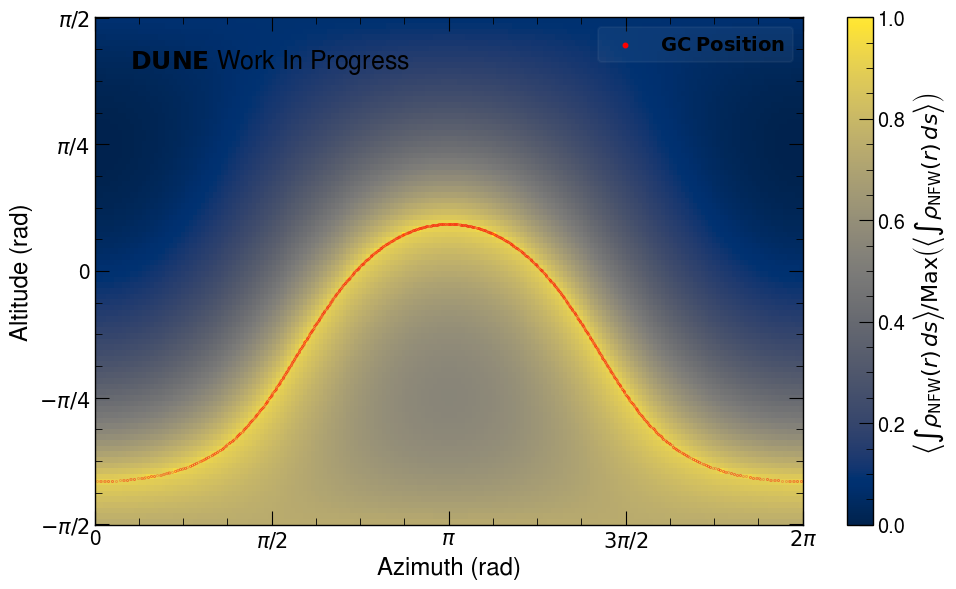

In [16]:
# Plot sum map
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
dunestyle.WIP(x=0.05, y=0.9)
ax.set_xticks([0.0,1.570,3.14159,4.7123,6.283])
ax.set_xticklabels([0,r'$\pi / 2$', r'$\pi$',r'$3\pi/2$', r'$2\pi$'], fontsize = 15)
ax.set_yticks([-1.570,-0.78539,0.0,0.78539,1.570])
ax.set_yticklabels([ r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$'], fontsize = 15)
plt.hist2d(np.radians(AZ_flat), np.radians(ALT_flat), weights=intensity_sum_norm,
           bins=[np.radians(az_edges), np.radians(alt_edges)])
gc_scatter = plt.scatter(gc_pos[:,0],gc_pos[:,1], marker='.', color='red', label = r'$\bf{GC\;Position}$', s =0.1)
cbar = plt.colorbar()
cbar.set_label(r'$ \left<\int \rho_\mathrm{NFW}(r)\,ds\right> /\text{Max}\left(\left<\int \rho_\mathrm{NFW}(r)\,ds\right>\right)$ ', fontsize=16)
plt.xlabel('Azimuth (rad)')
plt.ylabel('Altitude (rad)')

lgnd = plt.legend(handles=[gc_scatter],fontsize=14, frameon=True, framealpha=0.05)

# Fix marker size using the handles returned by legend
for handle in lgnd.legend_handles:
    handle.set_sizes([30])  # marker size in points²

plt.tight_layout()
plt.show()

In [14]:

def angular_distance(alt1, az1, alt2, az2):
    alt1, az1, alt2, az2 = map(np.radians, [alt1, az1, alt2, az2])
    return np.degrees(np.arccos(
        np.sin(alt1)*np.sin(alt2) + np.cos(alt1)*np.cos(alt2)*np.cos(az1 - az2)
    ))

cones_angle = np.linspace(5,180,36)

for cone in cones_angle:
    gc_fractions = []
    for i, t in enumerate(times):
        gc_altaz = gc_gal.transform_to(AltAz(obstime=t, location=dune_location))
        alt_gc = gc_altaz.alt.deg
        az_gc = gc_altaz.az.deg

        theta_deg = angular_distance(ALT_flat, AZ_flat, alt_gc, az_gc)
        mask_gc = theta_deg < cone   

        intensity_t = intensity_time_all[i]
        f_gc = intensity_t[mask_gc].sum() / intensity_t.sum()
        gc_fractions.append(f_gc)

    avg_fraction_gc = np.mean(gc_fractions)
    print(f"Average GC-aligned fraction (θ < {cone}°): {avg_fraction_gc:.5f}")

/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/leoperes/.local/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Average GC-aligned fraction (θ < 5.0°): 0.01067
Average GC-aligned fraction (θ < 10.0°): 0.03383
Average GC-aligned fraction (θ < 15.0°): 0.06598
Average GC-aligned fraction (θ < 20.0°): 0.10596
Average GC-aligned fraction (θ < 25.0°): 0.14815
Average GC-aligned fraction (θ < 30.0°): 0.19123
Average GC-aligned fraction (θ < 35.0°): 0.23476
Average GC-aligned fraction (θ < 40.0°): 0.27812
Average GC-aligned fraction (θ < 45.0°): 0.32126
Average GC-aligned fraction (θ < 50.0°): 0.36383
Average GC-aligned fraction (θ < 55.0°): 0.40595
Average GC-aligned fraction (θ < 60.0°): 0.44748
Average GC-aligned fraction (θ < 65.0°): 0.48867
Average GC-aligned fraction (θ < 70.0°): 0.52976
Average GC-aligned fraction (θ < 75.0°): 0.57217
Average GC-aligned fraction (θ < 80.0°): 0.61402
Average GC-aligned fraction (θ < 85.0°): 0.65377
Average GC-aligned fraction (θ < 90.0°): 0.69148
Average GC-aligned fraction (θ < 95.0°): 0.72724
Average GC-aligned fraction (θ < 100.0°): 0.76113
Average GC-aligned f

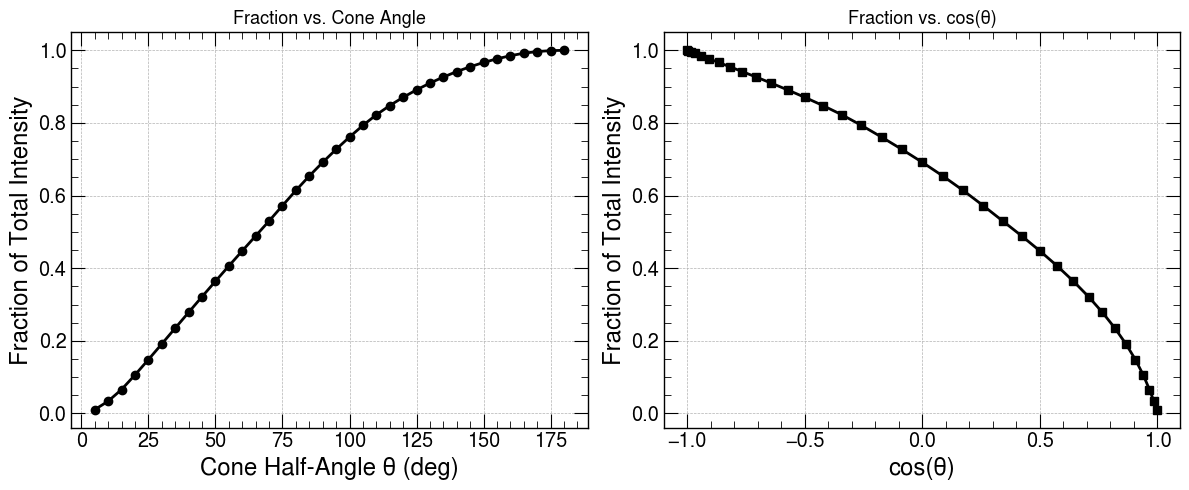

In [9]:

# Provided data
angles = np.arange(5, 181, 5)
fractions = np.array([
    0.01066, 0.03389, 0.06605, 0.10610, 0.14833, 0.19146, 0.23500, 0.27836,
    0.32150, 0.36408, 0.40616, 0.44769, 0.48888, 0.52996, 0.57231, 0.61413,
    0.65387, 0.69155, 0.72729, 0.76117, 0.79322, 0.82240, 0.84777, 0.87057,
    0.89111, 0.90969, 0.92641, 0.94142, 0.95473, 0.96646, 0.97657, 0.98510,
    0.99196, 0.99653, 0.99914, 1.00000
])

# Plot: angle vs. fraction
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(angles, fractions, marker='o')
plt.xlabel("Cone Half-Angle θ (deg)")
plt.ylabel("Fraction of Total Intensity")
plt.title("Fraction vs. Cone Angle", fontsize=13)
plt.grid(True)

# Plot: cos(theta) vs. fraction
plt.subplot(1, 2, 2)
cos_theta = np.cos(np.radians(angles))
plt.plot(cos_theta, fractions, marker='s')
plt.xlabel("cos(θ)")
plt.ylabel("Fraction of Total Intensity")
plt.title("Fraction vs. cos(θ)", fontsize=13)
plt.grid(True)

plt.tight_layout()
plt.show()

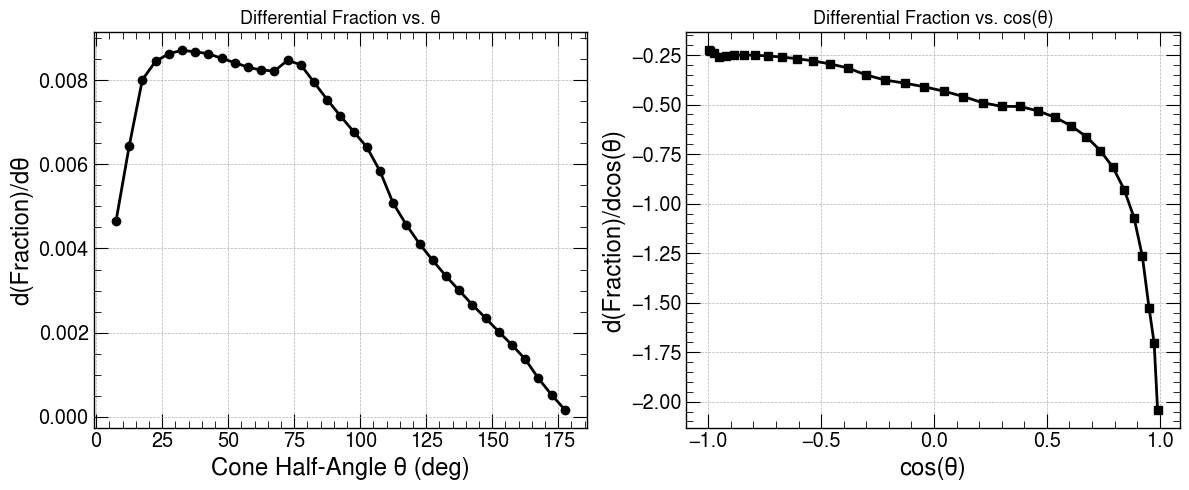

In [10]:
# Compute differentials
dtheta = np.diff(angles)
dfraction = np.diff(fractions)

# Midpoints for plotting differentials
theta_mid = 0.5 * (angles[:-1] + angles[1:])
cos_theta_mid = 0.5 * (np.cos(np.radians(angles[:-1])) + np.cos(np.radians(angles[1:])))

# Plot: dFraction/dθ vs θ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta_mid, dfraction / dtheta, marker='o')
plt.xlabel("Cone Half-Angle θ (deg)")
plt.ylabel("d(Fraction)/dθ")
plt.title("Differential Fraction vs. θ", fontsize=13)
plt.grid(True)

# Plot: dFraction/dcos(θ) vs cos(θ)
dcos_theta = np.diff(np.cos(np.radians(angles)))
plt.subplot(1, 2, 2)
plt.plot(cos_theta_mid, dfraction / dcos_theta, marker='s')
plt.xlabel("cos(θ)")
plt.ylabel("d(Fraction)/dcos(θ)")
plt.title("Differential Fraction vs. cos(θ)", fontsize=13)
plt.grid(True)

plt.tight_layout()
plt.show()

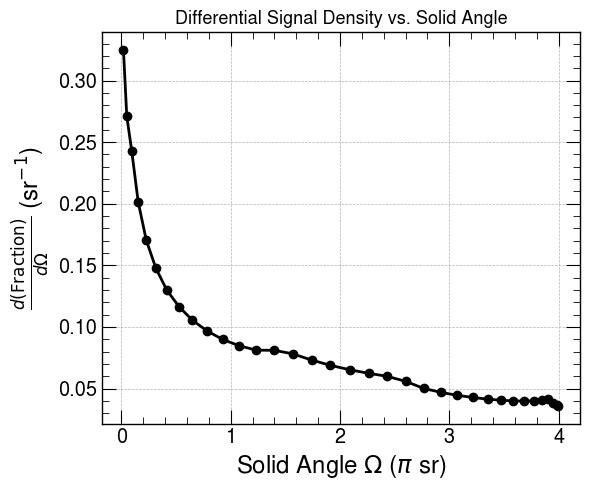

In [11]:
# Compute cumulative solid angle for each cone: Ω(θ) = 2π(1 - cosθ)
omega = 2 * np.pi * (1 - np.cos(np.radians(angles)))

# Compute differential fraction per steradian
domega = np.diff(omega)
dfraction_domega = dfraction / domega
omega_mid = 0.5 * (omega[:-1] + omega[1:])

# Convert x-axis (solid angle) to units of π steradians
omega_pi = omega_mid / np.pi

# Plot with x-axis in units of π
plt.figure(figsize=(6, 5))
plt.plot(omega_pi, dfraction_domega, marker='o')
plt.xlabel(r"Solid Angle $\Omega$ ($\pi$ sr)")
plt.ylabel(r"$\frac{d(\mathrm{Fraction})}{d\Omega}$ (sr$^{-1}$)")
plt.title("Differential Signal Density vs. Solid Angle", fontsize =13)
plt.grid(True)
plt.tight_layout()
plt.show()

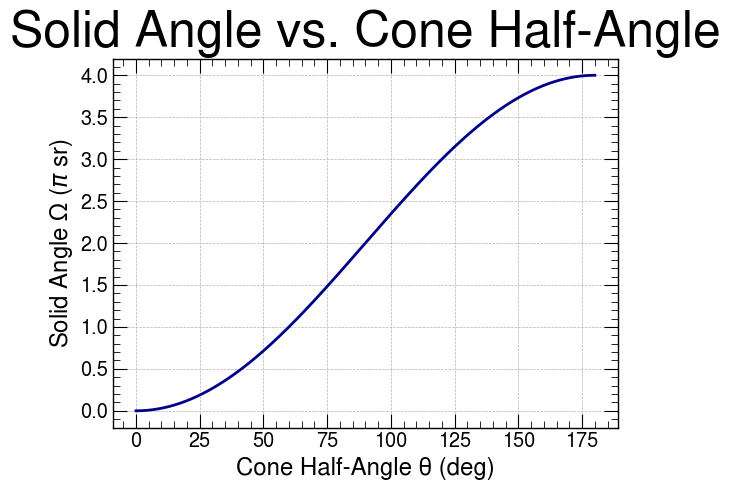

In [12]:
# Generate a fine grid of cone half-angles
theta_fine = np.linspace(0, 180, 500)  # degrees
omega_fine = 2 * np.pi * (1 - np.cos(np.radians(theta_fine)))  # sr

# Plot the theoretical relationship
plt.figure(figsize=(6, 5))
plt.plot(theta_fine, omega_fine / np.pi, color='darkblue')
plt.xlabel("Cone Half-Angle θ (deg)")
plt.ylabel(r"Solid Angle Ω ($\pi$ sr)")
plt.title("Solid Angle vs. Cone Half-Angle")
plt.grid(True)
plt.tight_layout()
plt.show()


<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_37149/3768051825.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel("Solid Angle Ω ($\pi$ sr)")


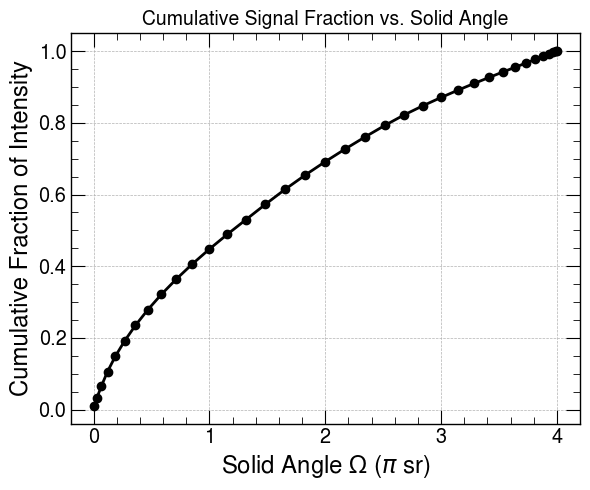

In [19]:
# Plot: cumulative fraction vs. cumulative solid angle (again for clarity)
plt.figure(figsize=(6, 5))
plt.plot(omega / np.pi, fractions, marker='o', linestyle='-')
plt.xlabel("Solid Angle Ω ($\pi$ sr)")
plt.ylabel("Cumulative Fraction of Intensity")
plt.title("Cumulative Signal Fraction vs. Solid Angle", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

FluxRotValues = np.array([[+0.9877, -0.1564, +0.0000],  # new x axis in old coordinates: be nice and fix things (ends up the same)
                        [+0.0000, +0.0000, +1.0000],  # new y axis in old coordinates: vertical
                        [-0.1564, -0.9877, +0.0000]])   # new z axis in old coordinates: away from Batavia, IL

In [ ]:
#z is orthogonal to earth surface pointing to the zenith, x points toward south and y toward east 
# Calculate Cartesian coordinates where:
# x-axis points towards geographic south
# y-axis points towards geographic east
# z-axis points towards zenith
x = np.sin(np.radians(AZ_flat)) * np.cos(np.radians(ALT_flat))
y = np.cos(np.radians(AZ_flat)) * np.cos(np.radians(ALT_flat))
z = np.sin(np.radians(ALT_flat))

arr = np.array([x,y,z])
    
arr_det = FluxRotValues.dot(arr)